# Imports

In [2]:
!pip install numerapi -q

In [3]:
import os
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numerapi as nai
from zipfile import ZipFile
from scipy.stats import spearmanr
from sklearn.metrics import r2_score
import re
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# Data Loading

Locally, we don't need to ping the API to pull data for every kernel reset

In [12]:
train_df = pd.read_csv('numerai_training_data.csv')

# Data Cleaning

In [4]:
train_df.head()

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,feature_intelligence11,feature_intelligence12,feature_charisma1,feature_charisma2,feature_charisma3,feature_charisma4,feature_charisma5,feature_charisma6,feature_charisma7,feature_charisma8,feature_charisma9,feature_charisma10,feature_charisma11,feature_charisma12,feature_charisma13,feature_charisma14,feature_charisma15,feature_charisma16,feature_charisma17,feature_charisma18,feature_charisma19,feature_charisma20,feature_charisma21,feature_charisma22,feature_charisma23,feature_charisma24,feature_charisma25,feature_charisma26,feature_charisma27,feature_charisma28,feature_charisma29,feature_charisma30,feature_charisma31,feature_charisma32,feature_charisma33,feature_charisma34,feature_charisma35,...,feature_constitution112,feature_constitution113,feature_constitution114,feature_wisdom1,feature_wisdom2,feature_wisdom3,feature_wisdom4,feature_wisdom5,feature_wisdom6,feature_wisdom7,feature_wisdom8,feature_wisdom9,feature_wisdom10,feature_wisdom11,feature_wisdom12,feature_wisdom13,feature_wisdom14,feature_wisdom15,feature_wisdom16,feature_wisdom17,feature_wisdom18,feature_wisdom19,feature_wisdom20,feature_wisdom21,feature_wisdom22,feature_wisdom23,feature_wisdom24,feature_wisdom25,feature_wisdom26,feature_wisdom27,feature_wisdom28,feature_wisdom29,feature_wisdom30,feature_wisdom31,feature_wisdom32,feature_wisdom33,feature_wisdom34,feature_wisdom35,feature_wisdom36,feature_wisdom37,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n000315175b67977,era1,train,0.00,0.50,0.25,0.00,0.5,0.25,0.25,0.25,0.75,0.75,0.25,0.25,1.00,0.75,0.5,1.0,0.5,0.00,0.50,0.50,0.00,0.0,0.00,1.00,0.25,0.00,0.50,0.25,0.75,0.50,1.00,0.75,0.75,0.5,0.50,0.75,0.5,0.25,0.75,0.75,0.50,0.25,0.25,0.50,0.25,0.50,0.25,...,0.50,0.50,0.25,0.25,1.00,0.75,0.50,0.75,0.75,0.75,0.75,0.75,0.75,0.50,1.00,1.00,0.50,0.75,0.5,0.25,0.25,0.75,0.50,1.00,0.5,0.75,0.75,0.25,0.50,1.00,0.75,0.50,0.50,1.00,0.25,0.5,0.50,0.50,0.75,1.00,1.00,1.00,0.75,0.50,0.75,0.50,1.00,0.50,0.75,0.50
1,n0014af834a96cdd,era1,train,0.00,0.00,0.00,0.25,0.5,0.00,0.00,0.25,0.50,0.50,0.00,0.50,0.00,0.50,0.5,0.5,0.5,0.50,0.25,0.25,0.50,0.0,1.00,0.50,0.50,0.50,0.75,0.50,0.50,0.75,0.25,0.50,0.75,0.5,0.25,0.75,0.5,0.50,0.50,0.75,0.50,0.50,0.75,0.25,0.50,0.25,0.50,...,0.00,1.00,0.75,0.50,1.00,0.00,0.25,0.00,1.00,1.00,0.25,0.25,0.25,1.00,1.00,0.50,0.50,0.50,0.0,0.25,1.00,0.50,1.00,1.00,0.5,0.50,0.50,1.00,0.25,0.75,1.00,0.25,0.25,1.00,0.50,0.5,0.50,0.75,0.75,0.75,1.00,1.00,0.00,0.00,0.75,0.25,0.00,0.25,1.00,0.25
2,n001c93979ac41d4,era1,train,0.25,0.50,0.25,0.25,1.0,0.75,0.75,0.25,0.00,0.25,0.50,1.00,0.50,0.75,0.5,0.5,1.0,0.50,0.50,0.50,0.25,0.0,0.25,0.75,0.75,0.75,0.50,0.75,0.50,0.25,0.50,0.75,0.25,0.5,0.50,0.75,0.5,0.50,0.25,0.75,0.75,0.50,0.75,0.00,0.75,0.50,0.75,...,0.00,0.25,0.00,1.00,0.50,1.00,0.75,0.00,1.00,0.75,0.25,1.00,1.00,1.00,0.50,1.00,1.00,1.00,0.5,1.00,0.00,1.00,1.00,0.50,1.0,0.75,1.00,0.00,0.50,0.75,0.00,1.00,0.50,0.50,0.75,1.0,0.75,1.00,0.25,0.50,0.25,0.50,0.00,0.00,0.50,1.00,0.00,0.25,0.75,0.25
3,n0034e4143f22a13,era1,train,1.00,0.00,0.00,0.50,0.5,0.25,0.25,0.75,0.25,0.50,0.50,0.50,0.75,0.50,1.0,0.5,0.5,0.00,1.00,0.00,0.75,0.0,0.50,0.50,0.50,0.50,0.00,0.50,0.50,0.75,0.75,0.50,0.25,0.5,0.50,0.50,0.5,0.50,0.50,0.50,0.75,0.50,0.50,1.00,0.50,0.50,0.50,...,0.75,0.25,0.25,1.00,1.00,1.00,1.00,0.75,0.75,1.00,1.00,1.00,0.75,0.75,1.00,0.75,0.75,0.75,1.0,0.75,1.00,0.75,1.00,0.75,1.0,0.00,0.50,0.75,1.00,0.75,1.00,0.75,1.00,1.00,0.00,0.5,0.75,0.75,1.00,0.75,1.00,1.00,0.75,0.75,1.00,1.00,0.75,1.00,1.00,0.25
4,n00679d1a636062f,era1,train,0.25,0.25,0.25,0.25,0.0,0.25,0.50,0.25,0.25,0.50,0.25,0.25,0.75,0.50,0.0,0.5,0.5,0.25,0.00,0.50,0.00,0.5,0.25,0.50,0.50,0.50,0.50,0.50,0.

In [15]:
def clean_data(df):
    clean_df = df.copy()
    featnames = [f for f in df if f.startswith("feature")]
# model training found in the examples do not 
# include the 'era' feature
#     featnames.append('era')
#     clean_df['era'] = df['era'].str.slice(3).astype(int)
    X = clean_df[featnames]
    y = clean_df['target']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 0.3, random_state=5)
        
    return X_train, X_test, y_train, y_test

In [16]:
X_train, X_test, y_train, y_test = clean_data(train_df)

# Model Setup

In [7]:
pipe = make_pipeline(LinearRegression())

# Model Training

In [8]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('linearregression', LinearRegression())])

# Model Evaluation

Numerai has some competition specific scoring methods. We have rank-correlation and regular correlation

In [9]:
preds = pipe.predict(X_test)

In [10]:
# spearmans correlation btwn predictions and target
def numerai_score(y_true, y_pred):
    return spearmanr(y_true, y_pred)


def correlation_score(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0,1]

In [11]:

score = r2_score(y_test, preds)
print(f"r2 Score: {score}")
print(f"Normal Correlation: {correlation_score(y_test, preds)}")
print(f"(Numerai Score): {numerai_score(y_test, preds)}")

r2 Score: 0.0019004237644421051
Normal Correlation: 0.044545018409113075
(Numerai Score): SpearmanrResult(correlation=0.042787128962431975, pvalue=6.016634910876282e-62)


# Model Save

In [12]:
joblib.dump(pipe, 'Models/pipe.pkl')

['Models/pipe.pkl']

## Model Exploration

Predicting on the entire dataset returns not very impressive results at all. This data is cleaned and obfuscated, so engineering features from this data will be a result of examining machine results and working backwards.

### First Search

We will implement various machine learning algorithms to get an idea of which ones perform at which levels. We will choose the best algorithms and then expand on this search in the next section.

In [13]:
def score(model, X_train, X_test, y_train, y_test):
    """
    Internal use for quick_and_dirty
    
    Scores a model with a dataset and
    returns metrics
    
    args:
    model - ml model to score
    df - dataset to use in scoring
    
    returns:
    model performance metrics
    """
    print("Fitting Model Now")
    model.fit(X_train, y_train)
    print("Predicting with Model Now")
    preds = model.predict(X_test)
    score = r2_score(y_test, preds)
    print(f"r2 Score: {score}")
    print(f"Normal Correlation: {correlation_score(y_test, preds)}")
    print(f"(Numerai Score): {numerai_score(y_test, preds)}")
    
def quick_model(df):
    """
    find promising model
    
    Trains a broad selection of different
    regression algorithms from the sklearn
    library. This function is meant to be
    used as a first-pass at selecting which
    models are best suited to solves a
    regression problem.
    
    args:
    df - the dataframe to perform ML on
    
    returns:
    output of model performances
    """
    from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
    from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor, ElasticNet, BayesianRidge, PoissonRegressor
    gbr = GradientBoostingRegressor()
    rfr = RandomForestRegressor(max_samples=0.1)
    lr = LinearRegression()
    r = Ridge()
    sgdr = SGDRegressor()
    en = ElasticNet()
    br = BayesianRidge()
    pr = PoissonRegressor()
    models = [gbr, rfr, lr, r, sgdr, en, br, pr]
    X_train, X_test, y_train, y_test = clean_data(df)
    for mod in models:
        print(mod)
        score(mod, X_train=X_train, X_test=X_test,
              y_train=y_train, y_test=y_test)
    return

In [14]:
quick_model(train_df)

GradientBoostingRegressor()
Fitting Model Now
Predicting with Model Now
r2 Score: 0.0022196532238080158
Normal Correlation: 0.047724737923815985
(Numerai Score): SpearmanrResult(correlation=0.046248777603705944, pvalue=4.4716572949495604e-72)
RandomForestRegressor(max_samples=0.1)
Fitting Model Now
Predicting with Model Now
r2 Score: -0.01038649860242069
Normal Correlation: 0.014390017644607284
(Numerai Score): SpearmanrResult(correlation=0.013048165084119594, pvalue=4.130463049044258e-07)
LinearRegression()
Fitting Model Now
Predicting with Model Now
r2 Score: 0.0019004237644421051
Normal Correlation: 0.044545018409113075
(Numerai Score): SpearmanrResult(correlation=0.042787128962431975, pvalue=6.016634910876282e-62)
Ridge()
Fitting Model Now
Predicting with Model Now
r2 Score: 0.0019006959059808537
Normal Correlation: 0.044546847332916834
(Numerai Score): SpearmanrResult(correlation=0.04278905261660443, pvalue=5.942142751138534e-62)
SGDRegressor()
Fitting Model Now
Predicting with Mo

/Users/davidcruz/miniconda3/envs/ml/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Predicting with Model Now
r2 Score: 0.0019460473251393662
Normal Correlation: 0.044664654908278305
(Numerai Score): SpearmanrResult(correlation=0.04400317293294172, pvalue=2.044905903672849e-65)
PoissonRegressor()
Fitting Model Now
Predicting with Model Now
r2 Score: 0.0005353459126146154
Normal Correlation: 0.03391190850531068
(Numerai Score): SpearmanrResult(correlation=0.03274200787610012, pvalue=5.396002117185694e-37)


#### Results

Notice that throughout results, we will continuously discuss r2 score and many of them will be negative. [This post](https://stats.stackexchange.com/questions/12900/when-is-r-squared-negative) helps us orient ourselves in what these scores mean. I am using this score at this point as an indicator that the model is capable of learning anything from the data.

Based on the above results, RandomForestRegressor shows to be one of our best candidates. Although the correlations produced are not the best out of the bunch, that can be optimized later on. For the Spearman results, the produced p-value is much closer to a realistic value that can be improved upon. Also, with r2-score of -.01, this is the strongest indicating signal that the model is predicting SOMETHING rather than noise. We can see the r2-score of the rest of the models fall into ranges of .00xxx, meaning that those models are closer to being defined as a model which explains none of the variance between the response variable and its mean.

A second interesting model is the gradient boosting regressor, which beats the rest of the models in terms of r2 score just slightly. Gradient boosting is a broad technique in ML and we can work with different algorithms which implement gradient boosting to see if we can expand on this slight edge in performance.

A third algorithm with notable performance is the SGDregressor. This model came in second in terms of confidence with the spearman correlation coefficient, which means that it is much closer to being a realistic indicator of performance on unseen data. SGD is also a great idea to expand upon, because it introduces randomness into the method for optimizing the model.

We should run a couple of more 'bare-bones' models to make sure that we choose the best. To continue this approach, I'll edit the above function to take a different list of models, and run through the training data one more time. We will build off of our observations above and focus on random forests and boosted models. 

### Second Search

#### Changes Made

Considering the models chosen above, we will now take steps in the (hopefully) right general direction by applying more advanced algorithms and ideas to our searching.

We will enhance gradient boosting by using the xtreme gradient boosting model, an adaptation of the gradient boosting regressor which utilizes parallel tree boosting to seriously increase efficiency. 

We will also enhance the capabilities of our random forest regressor,by raising the number of samples used to build each tree by 0.1. This will make the algorithm take longer to execute, but we should see a difference in results.

We will also experiment with Adaboost, another adaptation of gradient boosting which wraps an estimator in a gradient boosting object. Without setting parameters, we will see the performance of a decision tree regressor.

In [15]:
def quick_model(df):
    """
    find promising model
    
    Trains a broad selection of different
    regression algorithms from the sklearn
    library. This function is meant to be
    used as a first-pass at selecting which
    models are best suited to solves a
    regression problem.
    
    args:
    df - the dataframe to perform ML on
    
    returns:
    output of model performances
    """
    from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
    from sklearn.linear_model import SGDRegressor
    from xgboost import XGBRegressor
    abr = AdaBoostRegressor()
    xgb = XGBRegressor()
    gbr = GradientBoostingRegressor()
    rfr = RandomForestRegressor(max_samples=0.2)
    sgdr = SGDRegressor(penalty=None)
    models = [abr, xgb, gbr, rfr, sgdr]
    X_train, X_test, y_train, y_test = clean_data(df)
    for mod in models:
        print(mod)
        score(mod, X_train=X_train, X_test=X_test,
              y_train=y_train, y_test=y_test)
    return

In [16]:
quick_model(train_df)

AdaBoostRegressor()
Fitting Model Now
Predicting with Model Now
r2 Score: 0.00041859831320167906
Normal Correlation: 0.021127765395844877
(Numerai Score): SpearmanrResult(correlation=0.019751537167521056, pvalue=1.7987231835069024e-14)
XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)
Fitting Model Now
Predicting with Model Now
r2 Score: -0.01162828425422413
Normal Correl

#### Results


* The newly implemented adaboost did not perform impressively in either r2 Score or correlation, but it did provide a larger p-value than the rest of the models. Because a larger p-value indicates more confidence in predictions, this means that we should retain the idea of using some sort of gradient boosting for our final choice.
* The XGBRegressor produced a strong r2 score , although it was negative. This is something that could be corrected through enhanced parameters. The p-value associated with this regressor was also notable when compared ot the performance of a regular gradient boosting regressor. Our third model was a gradient boosting regressor and it had a lower r2 score, although it had a slightly higher correlation,the p-value was essentially half as small as that of the xgbregressor.
* Our Random forest regressor with added sampling again performed notably well. The r2 score had the strongest signal of all models (again, it performed worse than random, but we can correct this.) Overall, when considering the scoring of this model, it still shows to be a promising predictor.

### Next Steps

Based on the above results, we can conclude two things. First, is that Random Forest Regression shows to be the most promising model which can be modified to produce good predictions. Second, is that whenever the concept of boosting is applied to an algorithm, the results tend to score better than without boosting. For the final model selection, we will work to combine the efficiency of XGBoost with the predictive power of the random forest regressor. We will also create a distribution of parameters to conduct cross-validation, to ensure that we get the best performing model possible.

Up until this point, I've restricted myself to only documentation from the most popular libraries as well as knowledge from textbooks for potential modeling solutions. This is good practice for fundamentals in ml development and data science, but, to perform as best as possible, I will begin to utilize the most important learning resource for this competition; the community. Numerai's community is an entirely open-source community of data scientists who collaborate, share results, and help each other improve upon ideas to help gain more impressive results. Numerai itsself also provides a comprehensive amount of example material and directions to help newcomers get started with the competition.

 “If I have seen further it is by standing on the shoulders of Giants” - Isaac Newton

### Build the best model we can!

In [20]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

params = [{'max_depth': [5], 'learning_rate': [0.01, 0.05, 0.009],
          'n_estimators':[1000, 2000, 3000], 'n_jobs':[-1],
          'colsample_bytree': [0.1, 0.15]}]

model = XGBRegressor()

rcv = RandomizedSearchCV(model, params, cv=5,
                         return_train_score=True)

In [21]:
rcv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=...
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None,
                                          reg_al

In [22]:
rcv.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.15,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.009, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=2000, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [23]:
rcv.best_score_

0.0030261018845151753

In [24]:
preds = rcv.predict(X_test)
score = r2_score(y_test, preds)
print(f"r2 Score: {score}")
print(f"Normal Correlation: {correlation_score(y_test, preds)}")
print(f"(Numerai Score): {numerai_score(y_test, preds)}")

r2 Score: 0.0032868533081097384
Normal Correlation: 0.05748748034409029
(Numerai Score): SpearmanrResult(correlation=0.0564940101137895, pvalue=1.154080173305251e-106)


In [28]:
model = XGBRegressor(max_depth=5, learning_rate=0.01, n_estimators=20000,
                     num_leaves=2**5, n_jobs=-1, colsample_bytree=0.1)

model.fit(X_train, y_train)

preds = model.predict(X_test)
score = r2_score(y_test, preds)
print(f"r2 Score: {score}")
print(f"Normal Correlation: {correlation_score(y_test, preds)}")
print(f"(Numerai Score): {numerai_score(y_test, preds)}")

[22:24:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


r2 Score: -0.005219588971536959
Normal Correlation: 0.048749748742907204
(Numerai Score): SpearmanrResult(correlation=0.04751967508655768, pvalue=5.4270491092430485e-76)


The above model did not have as impressive results as desired. It just goes to show how difficult this competition actually is. Regardless, we will not give up! Next, we will try some unsupervised methods for clustering the data, to see if we have better luck at predicting values when using a subset of observations.

In [29]:
rcv.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.15,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.009, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=2000, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [31]:
joblib.dump(rcv.best_estimator_, 'xgb.pkl')

['xgb.pkl']

In [4]:
mod = joblib.load('xgb.pkl')

[11:26:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[11:26:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[11:26:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Py

In [17]:
len(X_train.columns)

310

In [13]:
len(mod.feature_importances_)

310

In [29]:
def feature_plot(importances, X_train, y_train,
                 num_of_importances):
    """
    plots feature importances for a given estimator
    
    args:
    importances(array) - array of feature importances given
    from estimator attributes
    X_train(array) - the training dataset features used to 
    train our estimator
    y_train(array) - the training data labels used to train
    our model
    num_of_importances(int) - number of features we are 
    interested in observing importance
    
    returns: a bar chart of feature importances for a given
    ML model
    
    """
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:num_of_importances]]
    values = importances[indices][:num_of_importances]
    fig = plt.figure(figsize=(9,5))
    plt.title(f"Weights for top {num_of_importances} features")
    plt.bar(np.arange(num_of_importances),
           values, width = 0.6, align="center",
           color = '#00A000', label = "Feature Weight")
    plt.bar(np.arange(num_of_importances) - 0.3,
           np.cumsum(values), width = 0.2, align = "center",
           color = '#00A0A0', 
           label = "Cumulative Feature Weight")
    plt.xticks(np.arange(num_of_importances), columns,
              rotation=90)
    plt.xlim((-0.5, num_of_importances-.05))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.show() 

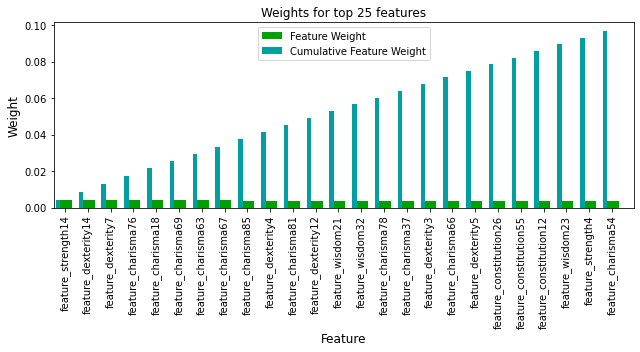

In [28]:
f_imp = mod.feature_importances_
feature_plot(f_imp, X_train, y_train, 25)

In [9]:
mod.feature_importances_

array([0.00313338, 0.003312  , 0.00315049, 0.00287384, 0.00302478,
       0.0030771 , 0.00313404, 0.00326649, 0.00245191, 0.00334549,
       0.0031599 , 0.00266864, 0.00328334, 0.00315007, 0.00301987,
       0.00298859, 0.00321378, 0.00355619, 0.00301725, 0.00318783,
       0.00353721, 0.00341381, 0.00326749, 0.00324669, 0.00314776,
       0.00294193, 0.00303392, 0.00311576, 0.00257775, 0.00414886,
       0.0033823 , 0.00252752, 0.00355981, 0.00306025, 0.00331152,
       0.0031755 , 0.00301493, 0.00347665, 0.003042  , 0.00316942,
       0.00326219, 0.00303023, 0.0023917 , 0.00297978, 0.00314554,
       0.00338003, 0.00333388, 0.00322004, 0.00370787, 0.002945  ,
       0.00315098, 0.00310203, 0.00310153, 0.00308957, 0.00312173,
       0.00320037, 0.0027941 , 0.0035142 , 0.00302808, 0.00310624,
       0.00300901, 0.003205  , 0.00312008, 0.00315456, 0.00308716,
       0.00359171, 0.00352346, 0.00313035, 0.00337318, 0.00348314,
       0.00282556, 0.00319433, 0.00331421, 0.00310262, 0.00395